In [1]:
import os
import json
import pyccl
import scipy
import numpy
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [ ]:
# Path
LABEL = 'POWER'
PATH = '/pscratch/sd/y/yhzhang/LimberCloud/'

DATA_PATH = os.path.join(PATH, 'DATA')
PLOT_PATH = os.path.join(PATH, 'PLOT', LABEL)

In [3]:
# Cosmology
with open(os.path.join(DATA_PATH, 'COSMOLOGY.json'), 'r') as cosmo:
    COSMOLOGY = json.load(cosmo)

CCL = pyccl.Cosmology(
    h = COSMOLOGY['H'],
    w0 = COSMOLOGY['W0'],
    wa = COSMOLOGY['WA'], 
    n_s = COSMOLOGY['NS'], 
    A_s = COSMOLOGY['AS'],
    m_nu = COSMOLOGY['MNU'],  
    Neff = COSMOLOGY['NEFF'],
    T_CMB = COSMOLOGY['TCMB'], 
    Omega_k = COSMOLOGY['OMEGAK'], 
    Omega_c = COSMOLOGY['OMEGAC'], 
    Omega_b = COSMOLOGY['OMEGAB'], 
    matter_power_spectrum = 'halofit',  
    transfer_function = 'boltzmann_camb', 
    extra_parameters = {'camb': {'kmax': 50, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [4]:
# Power
def power_m(chi_data, chi_grid, power_grid):
    
    ell_size = power_grid.shape[0]
    data_size = chi_data.shape[0] - 1
    grid_size = chi_grid.shape[0] - 1
    power = numpy.zeros((ell_size, data_size + 1))
    
    for k in range(data_size + 1):
        n = numpy.max(numpy.where(chi_grid <= chi_data[k]))
        
        if n < grid_size:
            if n == 0: 
                power[:,k] = chi_data[k] ** 3 / chi_grid[1]**3 * power_grid[:, 1]
            else:
                power[:,k] = (chi_grid[n + 1] - chi_data[k]) / (chi_grid[n + 1] - chi_grid[n]) * power_grid[:, n] + (chi_data[k] - chi_grid[n]) / (chi_grid[n + 1] - chi_grid[n]) * power_grid[:, n + 1]
        else:
            power[:,k] = 0
    
    return power

In [5]:
#Compare different numeric equations
# Size
Z1 = 0.0
Z2 = 3.5
GRID_SIZE = 350
Z_GRID = numpy.linspace(Z1, Z2, GRID_SIZE + 1)

A_GRID = 1 / (1 + Z_GRID)
CHI_GRID = pyccl.background.comoving_radial_distance(cosmo = CCL, a = A_GRID)

CHI_SIZE = 500
Z_DATA = numpy.linspace(Z1, Z2, CHI_SIZE + 1)

A_DATA = 1 / (1 + Z_DATA)
CHI_DATA = pyccl.background.comoving_radial_distance(cosmo = CCL, a = A_DATA)

ELL_SIZE = 4
ELL_DATA = [10, 100, 1000, 10000]
CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ELL_DATA)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE, GRID_SIZE + 1)) + numpy.inf, where = CHI_MESH > 0))

POWER_GRID = numpy.zeros((ELL_SIZE, GRID_SIZE + 1))
for GRID_INDEX in range(GRID_SIZE + 1):
    POWER_GRID[:,GRID_INDEX] = pyccl.power.nonlin_matter_power(cosmo = CCL, k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])
POWER_DATA = power_m(chi_data = CHI_DATA, chi_grid = CHI_GRID, power_grid = POWER_GRID)

POWER_DATA1 = scipy.interpolate.interp1d(CHI_GRID, POWER_GRID, kind = 'slinear')(CHI_DATA) 
POWER_DATA2 = scipy.interpolate.interp1d(CHI_GRID, POWER_GRID, kind = 'quadratic')(CHI_DATA)
POWER_DATA3 = scipy.interpolate.interp1d(CHI_GRID, POWER_GRID, kind = 'cubic')(CHI_DATA) 

CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_DATA, ELL_DATA)
SCALE_DATA = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE, CHI_SIZE + 1)) + numpy.inf, where = CHI_MESH > 0))

POWER_CCL = numpy.zeros((ELL_SIZE, CHI_SIZE + 1))
for DATA_INDEX in range(CHI_SIZE + 1):
    POWER_CCL[:,DATA_INDEX] = pyccl.power.nonlin_matter_power(cosmo = CCL, k = SCALE_DATA[:, DATA_INDEX], a = A_DATA[DATA_INDEX])

POWER_RATIO = numpy.divide(POWER_DATA, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)
POWER_RATIO1 = numpy.divide(POWER_DATA1, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)
POWER_RATIO2 = numpy.divide(POWER_DATA2, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)
POWER_RATIO3 = numpy.divide(POWER_DATA3, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)

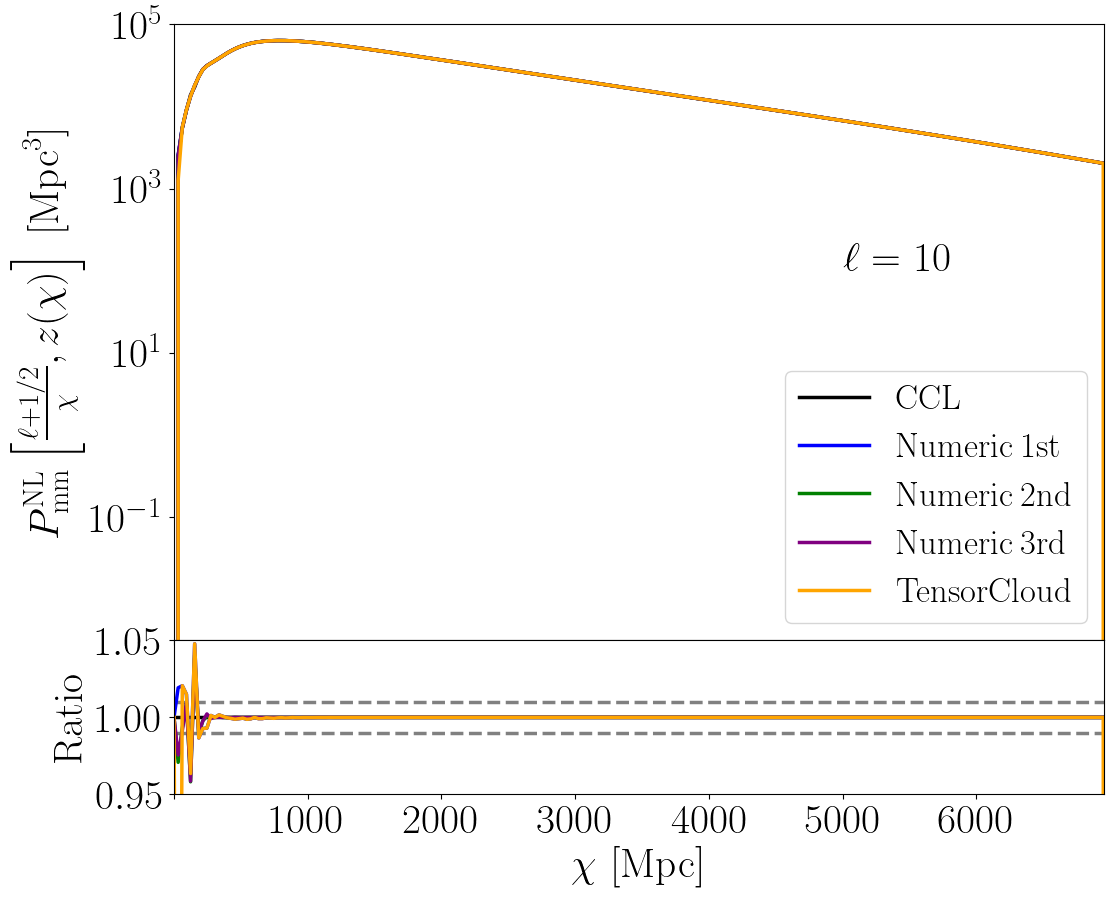

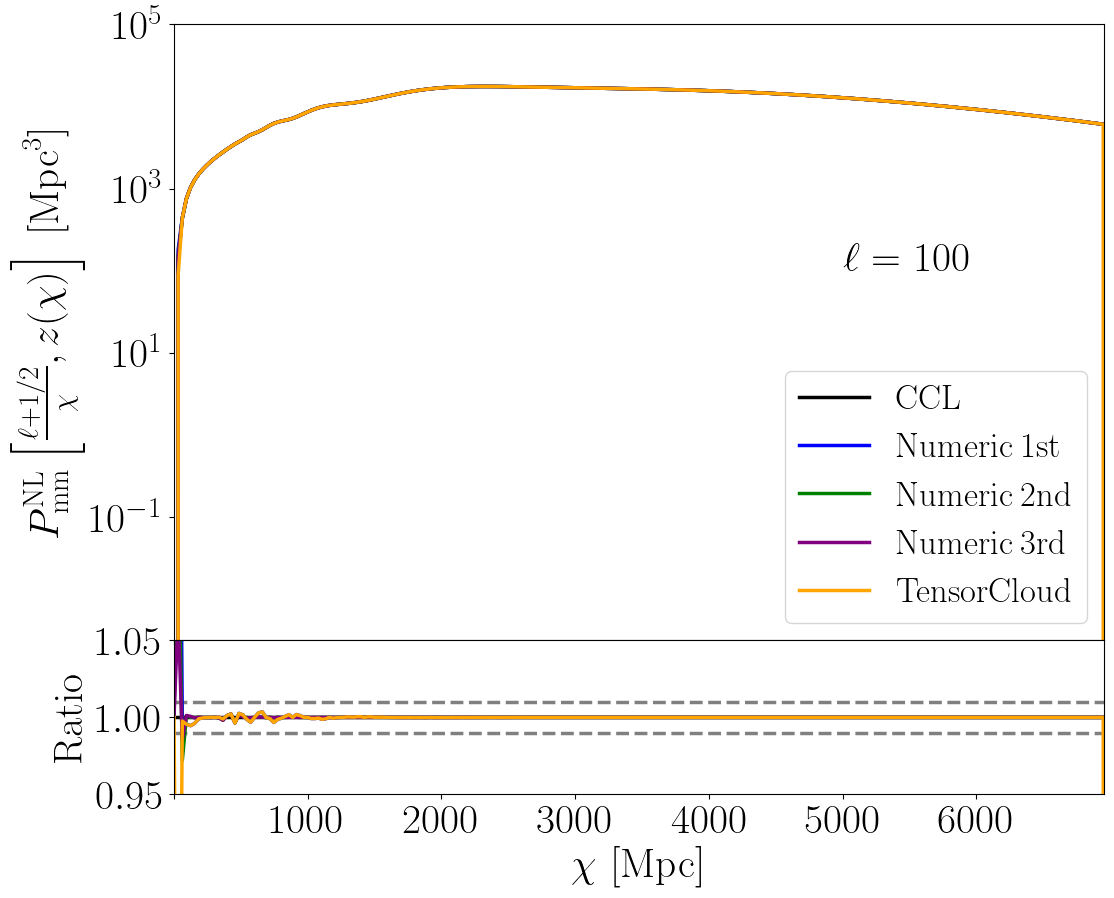

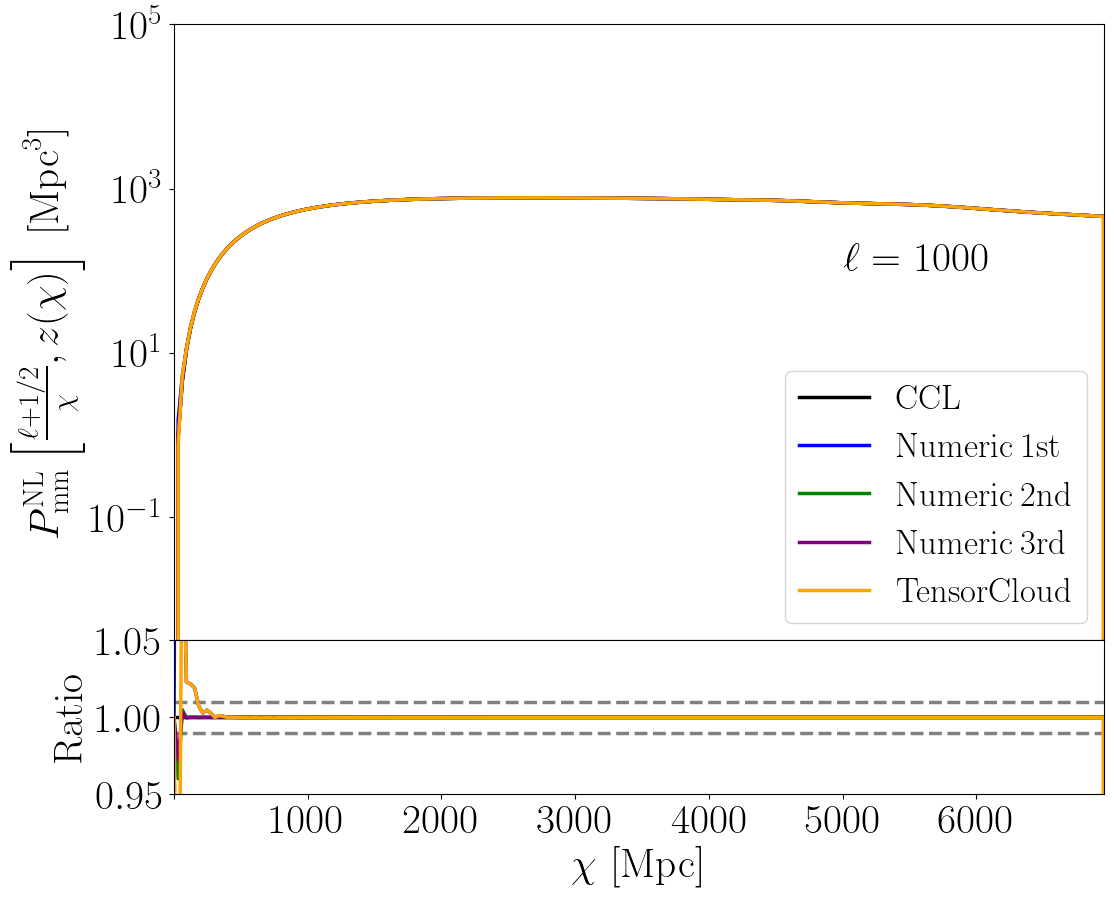

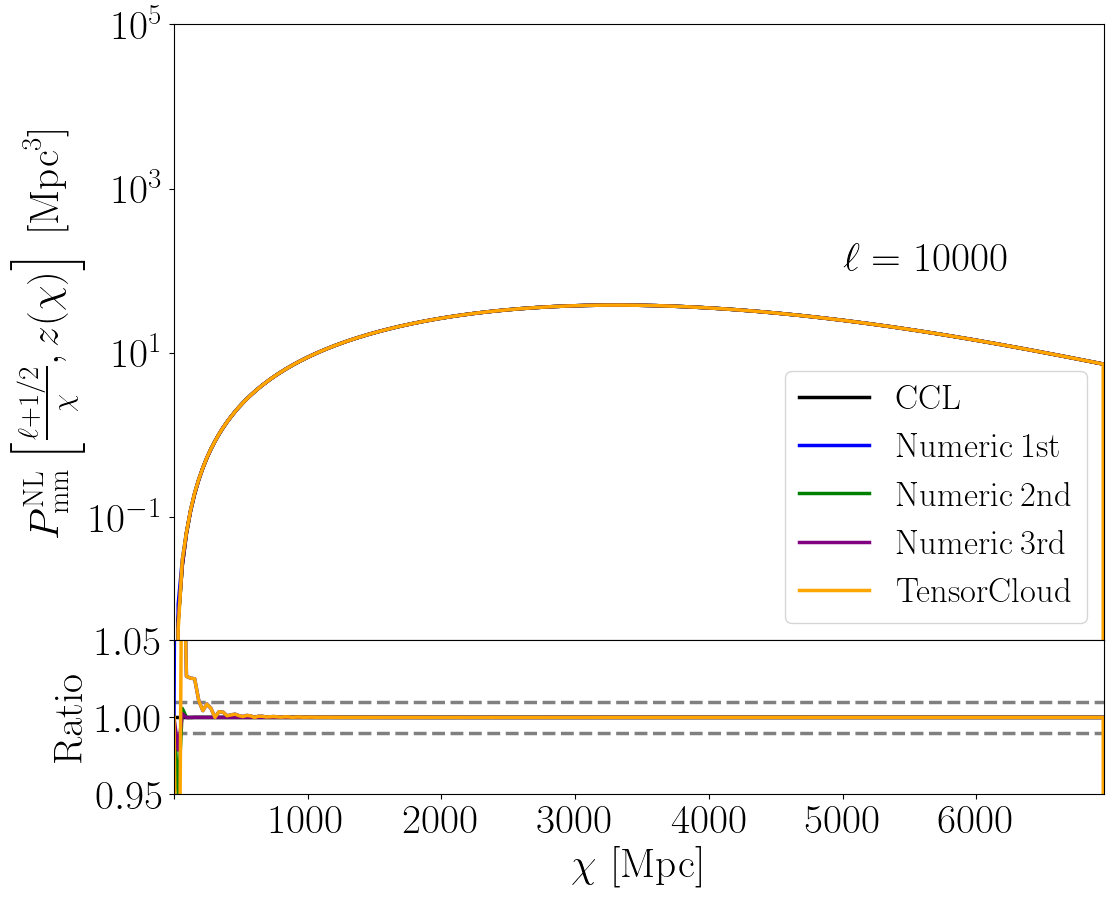

In [6]:
pyplot.rcParams['font.size'] = 30
pyplot.rcParams['text.usetex'] = True

for ELL_INDEX in range(ELL_SIZE):
    FIGURE = pyplot.figure(figsize = (12, 10))
    GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[0:8, :])
    
    PLOT.plot(CHI_DATA, POWER_CCL[ELL_INDEX, :], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')
    
    PLOT.plot(CHI_DATA, POWER_DATA1[ELL_INDEX, :], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')
    
    PLOT.plot(CHI_DATA, POWER_DATA2[ELL_INDEX, :], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')
    
    PLOT.plot(CHI_DATA, POWER_DATA3[ELL_INDEX, :], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')
    
    PLOT.plot(CHI_DATA, POWER_DATA[ELL_INDEX, :], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')
    
    PLOT.text(x = 5000, y = 100, s = r'$\ell = {:.0f}$'.format(ELL_DATA[ELL_INDEX]), fontsize = 30)
    
    PLOT.set_yscale('log')
    PLOT.set_ylim(10 ** -2.5, 10 ** +5.0)
    PLOT.set_xlim(CHI_DATA.min(), CHI_DATA.max()) 
    
    PLOT.legend(loc = 'lower right', fontsize = 25)
    PLOT.set_ylabel(r'$P_\mathrm{mm}^\mathrm{NL} \left[ \frac{\ell + 1/2}{\chi}, z(\chi) \right] \: [\mathrm{Mpc}^3]$', fontsize = 30)
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[8:, :])
    
    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)
    
    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)
    
    PLOT.plot(CHI_DATA, POWER_RATIO1[ELL_INDEX, :], color = 'blue', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(CHI_DATA, POWER_RATIO2[ELL_INDEX, :], color = 'green', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(CHI_DATA, POWER_RATIO3[ELL_INDEX, :], color = 'purple', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(CHI_DATA, POWER_RATIO[ELL_INDEX, :], color = 'orange', linestyle = '-', linewidth = 2.5)
    
    PLOT.set_ylim(1.00 - 0.05, 1.00 + 0.05)
    PLOT.set_xlim(CHI_DATA.min(), CHI_DATA.max())
    
    PLOT.set_ylabel(r'$\mathrm{Ratio}$')
    PLOT.get_xticklabels()[0].set_visible([])
    PLOT.set_xlabel(r'$\chi \, \left[ \mathrm{Mpc} \right]$')
    
    FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
    FIGURE.savefig(os.path.join(PLOT_PATH, 'POWER{}.pdf'.format(ELL_INDEX + 1)), bbox_inches = 'tight')